# Stochastic Oscillator strategy backtest:
%K = 100(C – L14)/(H14 – L14)
Where:

C = the most recent closing price

L14 = the low of the 14 previous trading sessions

H14 = the highest price traded during the same 14-day period

%K= the current market rate for the currency pair

%D = 3-period moving average of %K



In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from isharp.broker_client.remote_proxy import BrokerConnectionPool
from  isharp.broker_client.client_utils import mtx_headers_as_dataframe as to_df
matplotlib.rcParams['figure.dpi']= 100




In [165]:
with BrokerConnectionPool() as broker:
    apple =broker.checkout("arctic://localhost:5672/isharp/AAPL")    
    broker.release(apple)
    display(apple.content.head())
    
    

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-07-10,190.710007,191.279999,190.179993,190.350006,187.495941,15939100
2018-07-11,188.500000,189.779999,187.610001,187.880005,185.062973,18831500
2018-07-12,189.529999,191.410004,189.309998,191.029999,188.165741,18041100
2018-07-13,191.080002,191.839996,190.899994,191.330002,188.461243,12513900
2018-07-16,191.520004,192.649994,190.419998,190.910004,188.047531,15043100


Calculate L14 value and H14 values

In [166]:
df = apple.content
df['L14'] = df['Low'].rolling(window=14).min()
df['H14'] = df['High'].rolling(window=14).max()

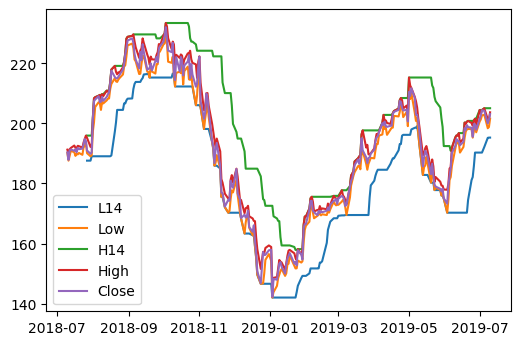

In [167]:

plt.plot(df.index.values,df['L14'])
plt.plot(df.index.values,df['Low'])
plt.plot(df.index.values,df['H14'])

plt.plot(df.index.values,df['High'])
plt.plot(df.index.values,df['Close'])
plt.legend(['L14','Low','H14','High','Close'])


plt.show()

Calcultate %K

In [168]:
df['%K'] = 100* (df['Close'] -df['L14']) / (df['H14'] - df['L14'])

Calculate %D

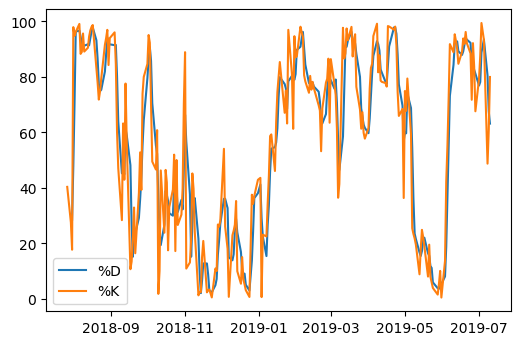

In [169]:
df['%D'] = df['%K'].rolling(window=3).mean()
plt.plot(df.index.values,df['%D'])
plt.plot(df.index.values,df['%K'])
plt.legend(['%D','%K'])
plt.show()

In [170]:
df['Sell Entry'] = ((df['%K'] < df['%D']) & (df['%K'].shift(1) > df['%D'].shift(1))) & (df['%D'] > 80) 
df['Sell Exit'] = ((df['%K'] > df['%D']) & (df['%K'].shift(1) < df['%D'].shift(1))) 
df['Short'] = np.nan 
df.loc[df['Sell Entry'],'Short'] = -1 
df.loc[df['Sell Exit'],'Short'] = 0 
df['Short'] = df['Short'].fillna(method='pad') 

In [171]:
df['Buy Entry'] = ((df['%K'] > df['%D']) & (df['%K'].shift(1) < df['%D'].shift(1))) & (df['%D'] < 20) 

#Create a column in the DataFrame showing "TRUE" if buy exit signal is given and "FALSE" otherwise. 
#A buy exit signal is given when the %K line crosses back down through the %D line 
df['Buy Exit'] = ((df['%K'] < df['%D']) & (df['%K'].shift(1) > df['%D'].shift(1))) 

#create a placeholder column to polulate with long positions (1 for long and 0 for flat) using boolean values created above 
df['Long'] = np.nan  
df.loc[df['Buy Entry'],'Long'] = 1  
df.loc[df['Buy Exit'],'Long'] = 0  


#Forward fill the position column to represent the holding of positions through time 
df['Long'] = df['Long'].fillna(method='pad') 

#Add Long and Short positions together to get final strategy position (1 for long, -1 for short and 0 for flat) 
df['Position'] = df['Long'] + df['Short']



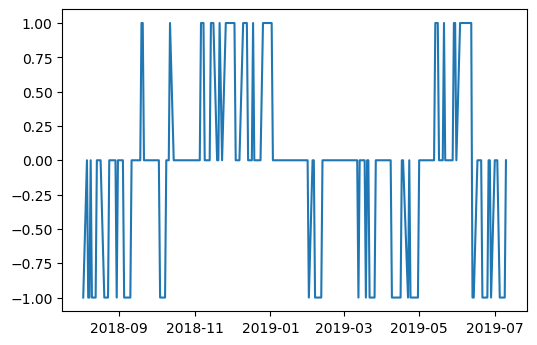

In [172]:
plt.plot(df.index.values,df['Position'])
plt.show()

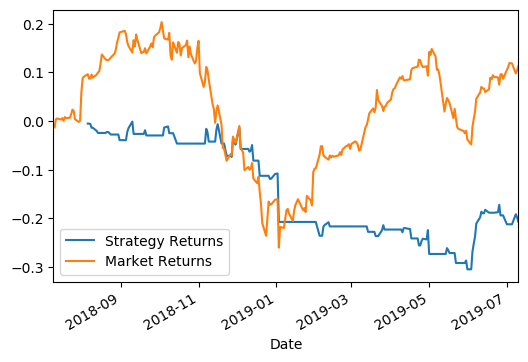

In [173]:
#Set up a column holding the daily Apple returns
df['Market Returns'] = df['Close'].pct_change()

#Create column for Strategy Returns by multiplying the daily Apple returns by the position that was held at close
#of business the previous day
df['Strategy Returns'] = df['Market Returns'] * df['Position'].shift(1)

#Finally plot the strategy returns versus Apple returns
df[['Strategy Returns','Market Returns']].cumsum().plot()